In [ ]:
# 1. Install Ultralytics
!pip install ultralytics

import os
import shutil
import random
from ultralytics import YOLO

# 2. Unzip your datasets
# Make sure you have uploaded 'metal_nut.zip' and 'screw.zip' to Colab
!tar -xvf metal_nut.tar.xz


In [ ]:
import os
import shutil
import random
from pathlib import Path

def get_counts(path):
    """Helper to count images in all subdirectories"""
    data_map = {}
    for root, dirs, files in os.walk(path):
        if not dirs: # It's a leaf folder containing images
            # Ensure the path is relative to the base 'path' argument
            folder_name = os.path.relpath(root, path)
            count = len([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            data_map[folder_name] = count
    return data_map

def prepare_with_report_revised(root_path, output_name, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    print(f"\n{'='*50}")
    print(f"REPORT FOR: {root_path.upper()}")
    print(f"{'='*50}")

    # --- 1. ANALYSIS BEFORE ---
    before_counts = get_counts(root_path)
    print("BEFORE RESTRUCTURING (Original MVTec Layout):")
    for folder, count in before_counts.items():
        print(f" - {folder}: {count} images")

    # --- 2. RESTRUCTURING LOGIC ---
    # Clean up previous output directory if it exists
    if os.path.exists(output_name):
        shutil.rmtree(output_name)

    # Collect all unique classes from both original train and test directories
    all_classes = set()
    # Add 'good' from train
    if os.path.exists(os.path.join(root_path, 'train', 'good')):
        all_classes.add('good')
    # Add all defect types from test
    if os.path.exists(os.path.join(root_path, 'test')):
        for d in os.listdir(os.path.join(root_path, 'test')):
            if os.path.isdir(os.path.join(root_path, 'test', d)):
                all_classes.add(d)

    # Create YOLO structure for all identified classes
    for split in ['train', 'val', 'test']:
        for cls in all_classes:
            os.makedirs(f"{output_name}/{split}/{cls}", exist_ok=True)

    # Process images for each class
    for cls in all_classes:
        all_images_for_class = []
        # Collect images from original 'train/good' if it's the 'good' class
        if cls == 'good' and os.path.exists(os.path.join(root_path, 'train', 'good')):
            train_good_path = os.path.join(root_path, 'train', 'good')
            all_images_for_class.extend([os.path.join(train_good_path, f) for f in os.listdir(train_good_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

        # Collect images from original 'test/<class_name>'
        if os.path.exists(os.path.join(root_path, 'test', cls)):
            test_class_path = os.path.join(root_path, 'test', cls)
            all_images_for_class.extend([os.path.join(test_class_path, f) for f in os.listdir(test_class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

        random.shuffle(all_images_for_class)

        total_images = len(all_images_for_class)
        num_train = int(total_images * train_ratio)
        num_val = int(total_images * val_ratio)
        # num_test = total_images - num_train - num_val
        num_test = total_images - num_train - num_val # calculate remaining for test

        train_images = all_images_for_class[:num_train]
        val_images = all_images_for_class[num_train:num_train + num_val]
        test_images = all_images_for_class[num_train + num_val:]

        # Copy images to new structure
        for img_path in train_images:
            shutil.copy(img_path, f"{output_name}/train/{cls}/{os.path.basename(img_path)}")
        for img_path in val_images:
            shutil.copy(img_path, f"{output_name}/val/{cls}/{os.path.basename(img_path)}")
        for img_path in test_images:
            shutil.copy(img_path, f"{output_name}/test/{cls}/{os.path.basename(img_path)}")

    # --- 3. ANALYSIS AFTER ---
    print(f"\nAFTER RESTRUCTURING (YOLOv8 Multi-Class Layout - Revised):")
    after_counts = get_counts(output_name)

    # Format the output for readability
    current_split = ""
    for folder in sorted(after_counts.keys()):
        split, cls = folder.split('/')
        if split != current_split:
            print(f"\n[{split.upper()} SPLIT]")
            current_split = split
        print(f"  - {cls}: {after_counts[folder]} images")

# Run the revised process
prepare_with_report_revised('metal_nut', 'data_nut')


In [ ]:
# --- TRAIN METAL NUT ---
nut_model = YOLO('yolov8n-cls.pt')
nut_model.train(
    data='/content/data_nut',
    epochs=30,
    imgsz=224,
    batch=16,
    name='nut_classifier',
    augment=True  # Helpful for hitting >85%
)



Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data_nut, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=nut_classifier2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a542a0ee510>
curves: []
curves_results: []
fitness: 0.9313725531101227
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.8627451062202454, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9313725531101227}
save_dir: PosixPath('/content/runs/classify/nut_classifier2')
speed: {'preprocess': 0.2855138039230238, 'inference': 1.095109764706007, 'loss': 0.00037072549293596096, 'postprocess': 0.00047501960883285693}
task: 'classify'
top1: 0.8627451062202454
top5: 1.0

In [ ]:
# Evaluate Metal Nut
print("--- Evaluating Metal Nut Model ---")
nut_results = nut_model.val(data='/content/data_nut', split='test')
print(f"Nut Accuracy: {nut_results.top1 * 100:.2f}%")


--- Evaluating Metal Nut Model ---
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
train: /content/data_nut/train... found 148 images in 5 classes ✅ 
val: /content/data_nut/val... found 51 images in 5 classes ✅ 
test: /content/data_nut/test... found 58 images in 5 classes ✅ 
test: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3047.4±1922.8 MB/s, size: 488.6 KB)
test: Scanning /content/data_nut/test... 57 images, 1 corrupt: 100% ━━━━━━━━━━━━ 57/57 121.2Kit/s 0.0s
test: /content/data_nut/test/good/201.png: ignoring corrupt image/label: Truncated File Read
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 4/4 3.2it/s 1.3s
                   all      0.965          1
Speed: 1.2ms preprocess, 1.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/val2
Nut Accuracy: 96.49%


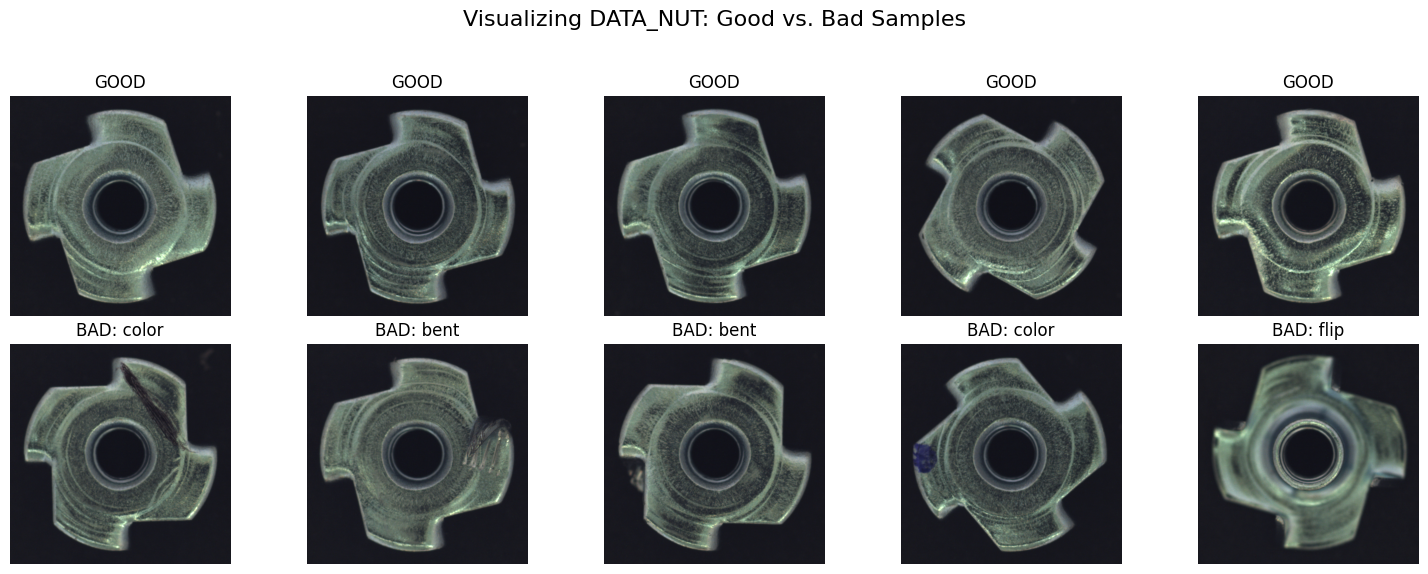

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import cv2

def visualize_samples(dataset_path, num_samples=5):
    # Setup paths for 'good' and a collection of 'bad' samples
    train_path = os.path.join(dataset_path, 'train')
    good_dir = os.path.join(train_path, 'good')

    # Identify defect folders (all folders in train except 'good')
    defect_dirs = [d for d in os.listdir(train_path) if d != 'good']

    # Collect images
    good_images = [os.path.join(good_dir, f) for f in os.listdir(good_dir)]
    bad_images = []
    for d in defect_dirs:
        d_path = os.path.join(train_path, d)
        bad_images.extend([os.path.join(d_path, f) for f in os.listdir(d_path)])

    # Randomly select samples
    selected_good = random.sample(good_images, num_samples)
    selected_bad = random.sample(bad_images, num_samples)

    # Plotting
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    fig.suptitle(f'Visualizing {os.path.basename(dataset_path).upper()}: Good vs. Bad Samples', fontsize=16)

    for i in range(num_samples):
        # Plot Good images in first row
        img_good = cv2.cvtColor(cv2.imread(selected_good[i]), cv2.COLOR_BGR2RGB)
        axes[0, i].imshow(img_good)
        axes[0, i].set_title("GOOD")
        axes[0, i].axis('off')

        # Plot Bad images in second row
        img_bad_path = selected_bad[i]
        defect_type = os.path.basename(os.path.dirname(img_bad_path))
        img_bad = cv2.cvtColor(cv2.imread(img_bad_path), cv2.COLOR_BGR2RGB)
        axes[1, i].imshow(img_bad)
        axes[1, i].set_title(f"BAD: {defect_type}")
        axes[1, i].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run for both datasets
visualize_samples('data_nut')


In [ ]:
#Evaluation meterics
from sklearn.metrics import roc_auc_score , roc_curve
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import os

def calculate_auroc_fixed(model_path, data_path):

    model = YOLO(model_path)
    y_true = []
    y_scores = []

    # Identify the index of the 'good' class dynamically
    good_idx = [k for k, v in model.names.items() if v == 'good'][0]
    print(f"Detected 'good' class at index: {good_idx}")

    # Use the VAL folder because it actually contains both Good and Bad images
    val_path = os.path.join(data_path, 'val')

    for class_dir in os.listdir(val_path):
        is_bad = 0 if class_dir == 'good' else 1
        class_path = os.path.join(val_path, class_dir)

        if not os.path.isdir(class_path): continue

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            results = model(img_path, verbose=False)

            # Get probability of the 'good' class and invert it for 'bad' score
            probs = results[0].probs.data
            good_prob = probs[good_idx].item()
            bad_prob = 1 - good_prob

            y_true.append(is_bad)
            y_scores.append(bad_prob)

    # Calculate AU ROC
    auroc = roc_auc_score(y_true, y_scores)
    print(f"✅ Fixed AU ROC (using Val Set): {auroc:.4f}")

    # Plotting for your report
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr, label=f'ROC Curve (area = {auroc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Performance Curve')
    plt.legend()
    plt.show()

    return y_true, y_scores

# Run it on your Nut data
# Use 'data_nut' (the root of the restructured data)
y_true, y_scores = calculate_auroc_fixed('/content/runs/classify/2/weights/best.pt', '/content/data_nut')

FileNotFoundError: [Errno 2] No such file or directory: '/content/runs/classify/2/weights/best.pt'

In [ ]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=10959878d5cf94cb9e32ef19f9b399518aa2bd00c4b47e8122eee1990bce858e
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


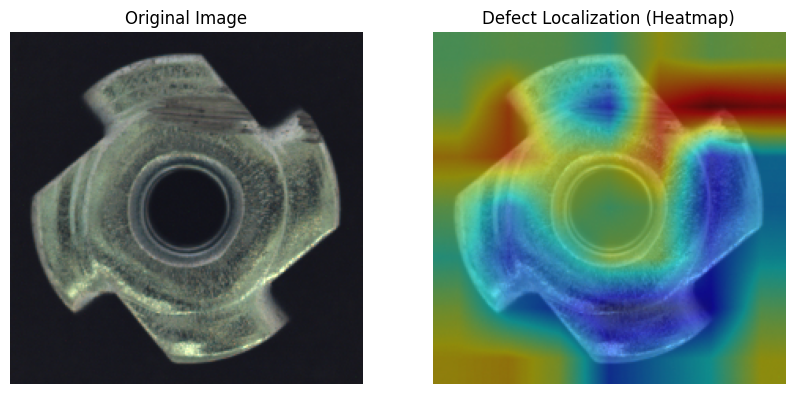

In [ ]:
import pytorch_grad_cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import torch
import cv2 # Import cv2
import matplotlib.pyplot as plt # Import matplotlib.pyplot

def generate_defect_heatmap(model_path, img_path):
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 1. Load Model
    yolo_model = YOLO(model_path)
    inner_model = yolo_model.model
    inner_model.to(device) # Move model to GPU

    # 2. Prepare Image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    rgb_img = np.float32(img) / 255
    input_tensor = torch.from_numpy(np.transpose(rgb_img, (2, 0, 1))).unsqueeze(0).float().requires_grad_(True)
    input_tensor = input_tensor.to(device) # Move input tensor to GPU

    # 3. Setup Grad-CAM on the last convolutional layer
    # For YOLOv8-cls, this is usually the second to last layer
    target_layers = [inner_model.model[-2]]
    cam = GradCAM(model=inner_model, target_layers=target_layers)

    # 4. Generate Heatmap
    # The YOLO model expects an image path or a PIL image for prediction, not a raw tensor
    # Running the prediction again with the image path to get results properly
    results = yolo_model(img_path, verbose=False)
    target_class_index = results[0].probs.top1 # Get the index of the predicted top class
    targets = [ClassifierOutputTarget(target_class_index)] # Pass the index to ClassifierOutputTarget

    # For GradCAM, the input tensor should be on the same device as the model
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

    # 5. Overlay Heatmap on Original Image
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # 6. Display
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Defect Localization (Heatmap)")
    plt.imshow(visualization)
    plt.axis('off')
    plt.show()

#Run it on a defect
generate_defect_heatmap('runs/classify/nut_classifier2/weights/best.pt', '/content/metal_nut/test/scratch/005.png')

In [ ]:
from google.colab import files

# Path to the best.pt file
model_path = '/content/runs/classify/nut_classifier2/weights/best.pt'

# Download the file
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>